In [19]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import FNO
from models.pfno import PNO_Wrapper, PFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset, KSDataset, ERA5Dataset
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
import cmcrameri.cm as cmc
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

# Load best predictions

In [2]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [3]:
data_dir = "../../data/era5/"
train_data = ERA5Dataset(data_dir, var="train")
val_data = ERA5Dataset(data_dir, var="val")
test_data = ERA5Dataset(data_dir, var = "test")

lat,lon,t = train_data.get_coordinates(normalize = False)
L = train_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

data_mean = train_data.mean
data_std = train_data.std

n_train = len(train_loader)
n_test = len(val_loader)

In [5]:
path = "../../results/era5_results/"

dropout_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)

base_model_cp = torch.load(path+"dropout.pt", map_location=torch.device(device))
dropout_model.load_state_dict(base_model_cp)

laplace_cp = torch.load(path+"laplace.pt", map_location=torch.device(device))
laplace_model = copy.deepcopy(dropout_model)
laplace_model.load_state_dict(laplace_cp)
la_model = LA_Wrapper(laplace_model)
la_model.fit(val_loader)
la_model.optimize_precision()

# pfno_model = PFNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)
# pfno_cp = torch.load(path+"sr_reparam.pt", map_location=torch.device(device))
# pfno_model.load_state_dict(pfno_cp)

pfno_model = PNO_Wrapper(copy.deepcopy(dropout_model)).to(device)
pfno_cp = torch.load(path+"sr_dropout.pt", map_location=torch.device(device))
pfno_model.load_state_dict(pfno_cp)

/tmp/ipykernel_18374/1251105867.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model_cp = torch.load(path+"dropout.pt", map_location=torch.device(device))
/tmp/ipy

<All keys matched successfully>

# Predictions

In [6]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy() * data_std + data_mean
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy() * data_std + data_mean
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy() * data_std + data_mean

In [94]:
idx = 1

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy() * data_std + data_mean

preds = [pred_dropout[idx], pred_la[idx], pred_pfno[idx]]
names = ['MCDropout','Laplace approximation', 'PFNO']

In [95]:
def plot_statistics(truth, preds, names, grid, t, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth[:,:,t].squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = (truth - pred_array.mean(axis = -1)).min(), vmax = (truth - pred_array.mean(axis = -1)).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (18,10), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m, pred in enumerate(preds):        
        pred = pred[:,t].squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,(truth - pred.mean(axis = -1)), shading = "nearest", cmap = "cmc.vik", norm = mse_norm)
        im2 = axs[1,m].pcolormesh(lon, lat,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla", norm = std_norm)
        im3 = axs[2,m].pcolormesh(lon, lat,coverage, shading = "nearest", cmap = cmap_coverage)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])
    axs[2,0].set_xticks([])
    axs[2,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

MCDropout- Coverage: 0.4059943181818182
Laplace approximation- Coverage: 0.5013352272727273
PFNO- Coverage: 0.6457670454545454


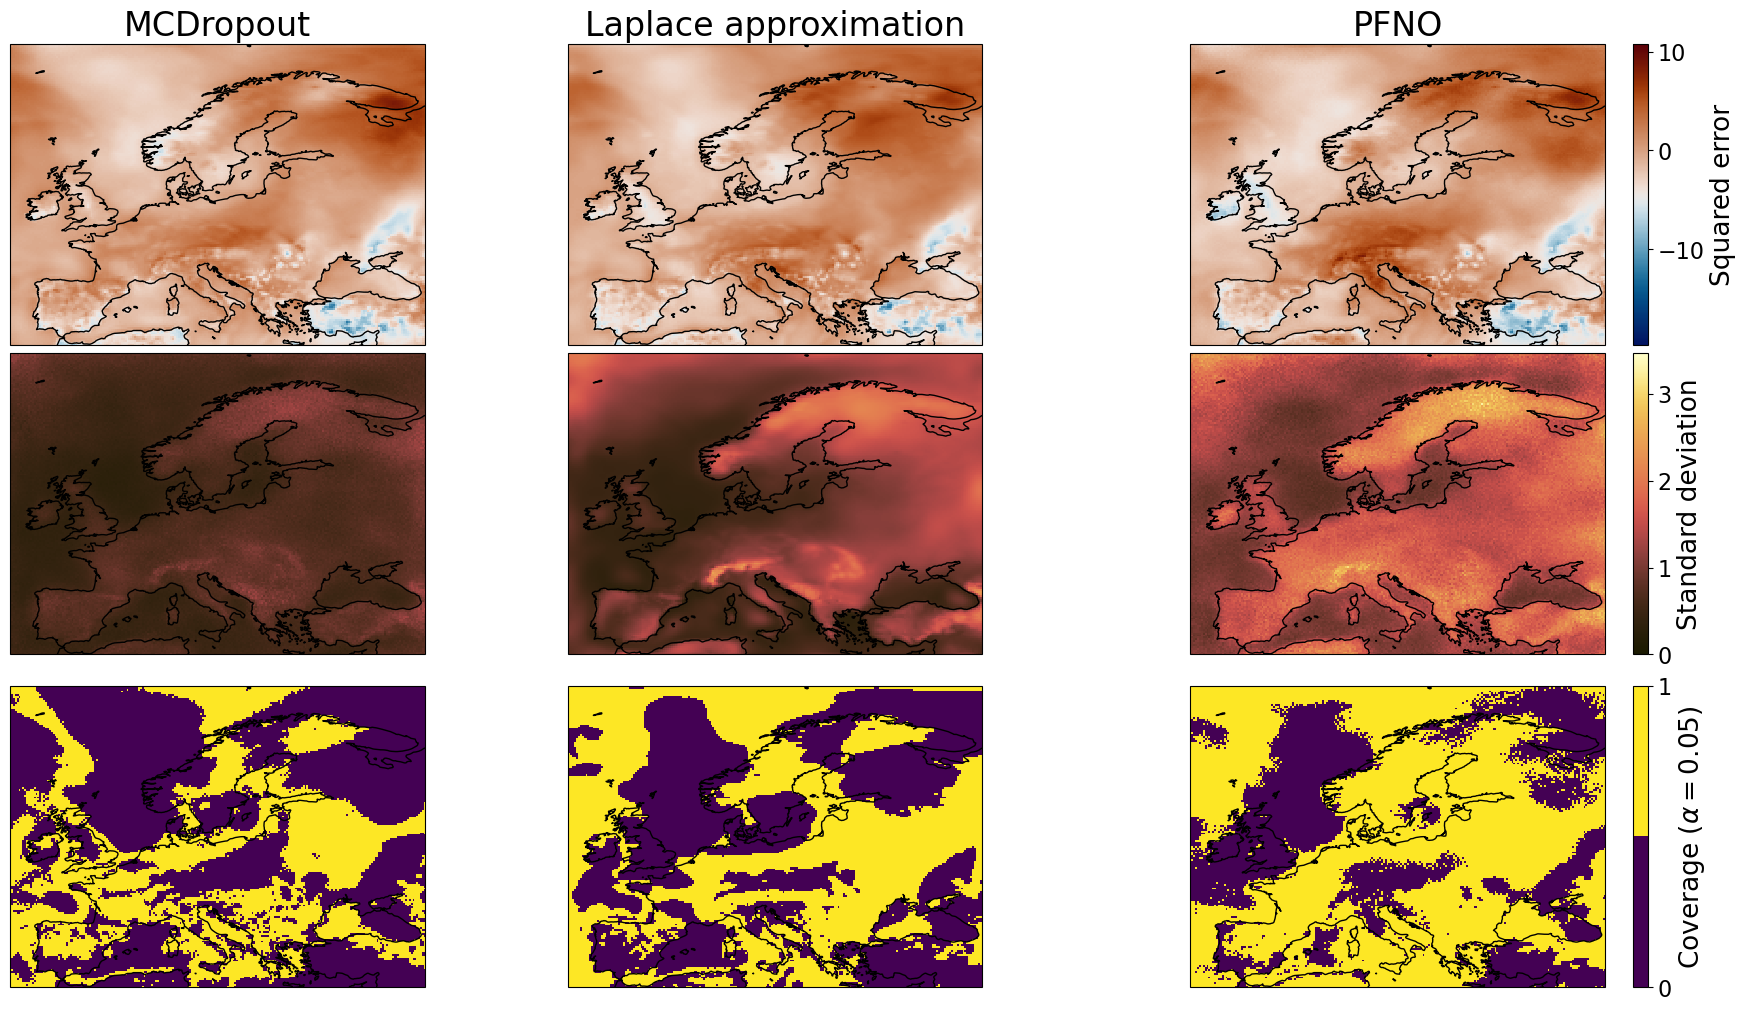

In [96]:
plot_statistics(u, preds, names, (lat,lon), t = 9, save_path = "plots/era5_statistics.png", alpha = 0.05)

# Plot Coverage only

In [97]:
def plot_coverage(truth, preds, names, grid, t, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth[:,:,t].squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    fig, axs = plt.subplots(1,n_models, figsize = (20,5), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m, pred in enumerate(preds):        
        pred = pred[:,t].squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im3 = axs[m].pcolormesh(lon, lat,coverage, shading = "nearest", cmap = cmap_coverage)
        axs[m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb3 = fig.colorbar(im3, ax = axs[m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(rf"Coverage ($\alpha = {alpha}$)",size=title_size)
    axs[0].set_xticks([])
    axs[0].set_yticks([])


    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

MCDropout- Coverage: 0.5098863636363636
Laplace approximation- Coverage: 0.8013636363636364
PFNO- Coverage: 0.8943181818181818


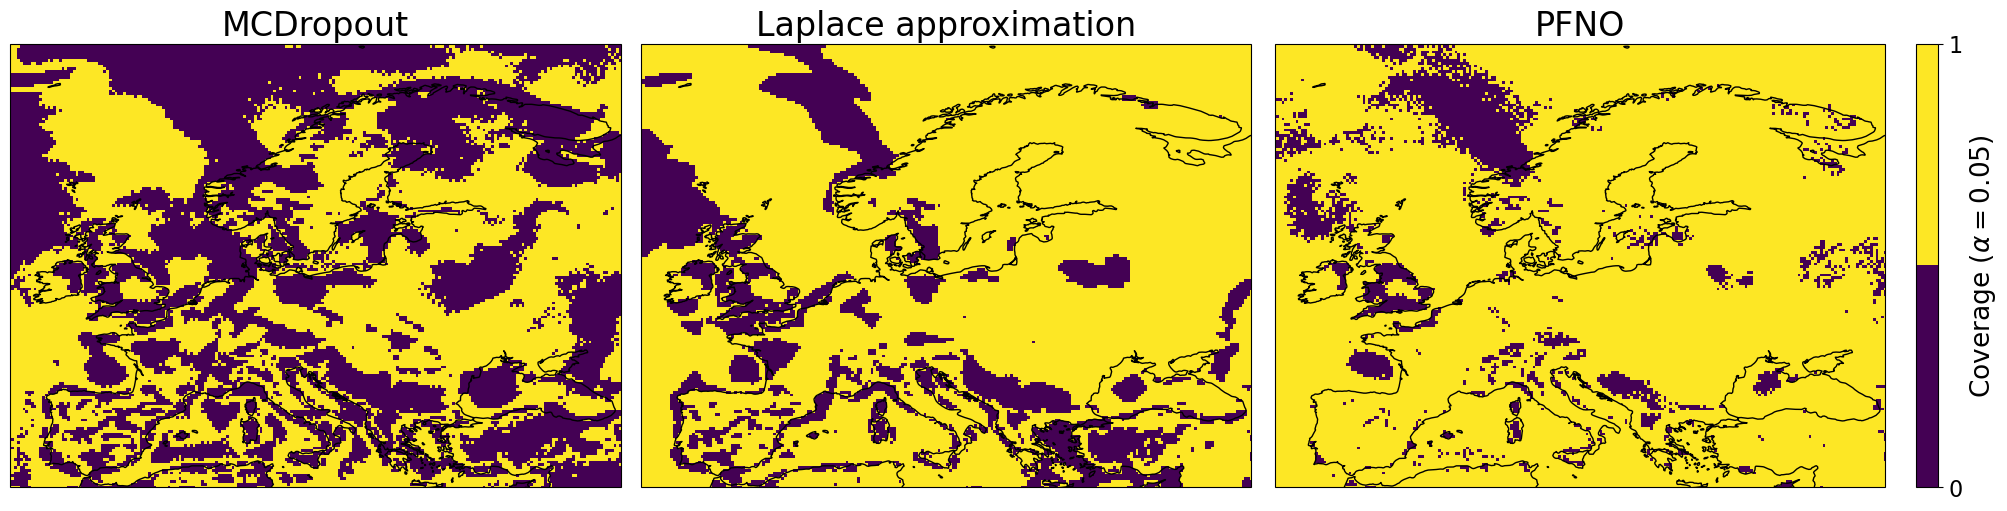

In [104]:
plot_coverage(u, preds, names, (lat,lon), t = 0, save_path = "plots/era5_coverage.png", alpha = 0.05)

# Plot CRPS values

In [ ]:
class CRPS(object):
    def __init__(self, reduction="mean", reduce_dims=True, **kwargs):
        super().__init__()

        self.reduction = reduction
        self.reduce_dims = reduce_dims

    def reduce(self, x):
        if self.reduction == "sum":
            x = torch.sum(x, dim=0, keepdim=True)
        else:
            x = torch.mean(x, dim=0, keepdim=True)
        return x

    def calculate_score(self, x, y):
        """Calculates the energy score for different metrics

        Args:
            x (_type_): Model prediction (Batch size, ..., n_samples)
            y (_type_): Target (Batch size, ..., 1)
            h (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: Energy score
        """
        n_samples = x.size()[-1]

        # Add additional dimension if necessary
        if len(x.size()) != len(y.size()):
            y = torch.unsqueeze(y, dim=-1)

        # Flatten tensors
        x_flat = torch.flatten(x, start_dim=1, end_dim=-2)
        y_flat = torch.flatten(y, start_dim=1, end_dim=-2)

        # Calculate CRPS
        term_1 = torch.abs(x_flat - y_flat).mean(dim = -1)
        term_2 = torch.abs(
            torch.unsqueeze(x_flat, dim=-1) - torch.unsqueeze(x_flat, dim=-2)
        ).mean(dim = (-2,-1))
        score = term_1 - 0.5*term_2 
        if self.reduce_dims:
            # Aggregate CRPS over spatial dimensions
            score = score.mean(dim = -1)

        # Reduce
        return self.reduce(score).squeeze() if self.reduce_dims else score

    def __call__(self, y_pred, y, **kwargs):
        return self.calculate_score(y_pred, y, **kwargs)

In [ ]:
crps = CRPS(reduce_dims = False)
with torch.no_grad():    
    sample = samples[idx]
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    
    dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples).cpu()
    pfno_pred = pfno_model(a, n_samples = n_samples).cpu()
    la_pred = la_model.predictive_samples(a).cpu()
    u = u.cpu()

In [ ]:
pfno_crps = crps(pfno_pred, u).reshape(u.shape)
dropout_crps = crps(dropout_pred, u).reshape(u.shape)
la_crps = crps(la_pred, u).reshape(u.shape)

In [ ]:
preds = [pfno_crps, la_crps, dropout_crps]
names = ['PFNO', 'LA', "Dropout"]

In [ ]:
print(pfno_crps.mean().item(), la_crps.mean().item(), dropout_crps.mean().item())

0.019240833818912506 0.018803533166646957 0.019140245392918587


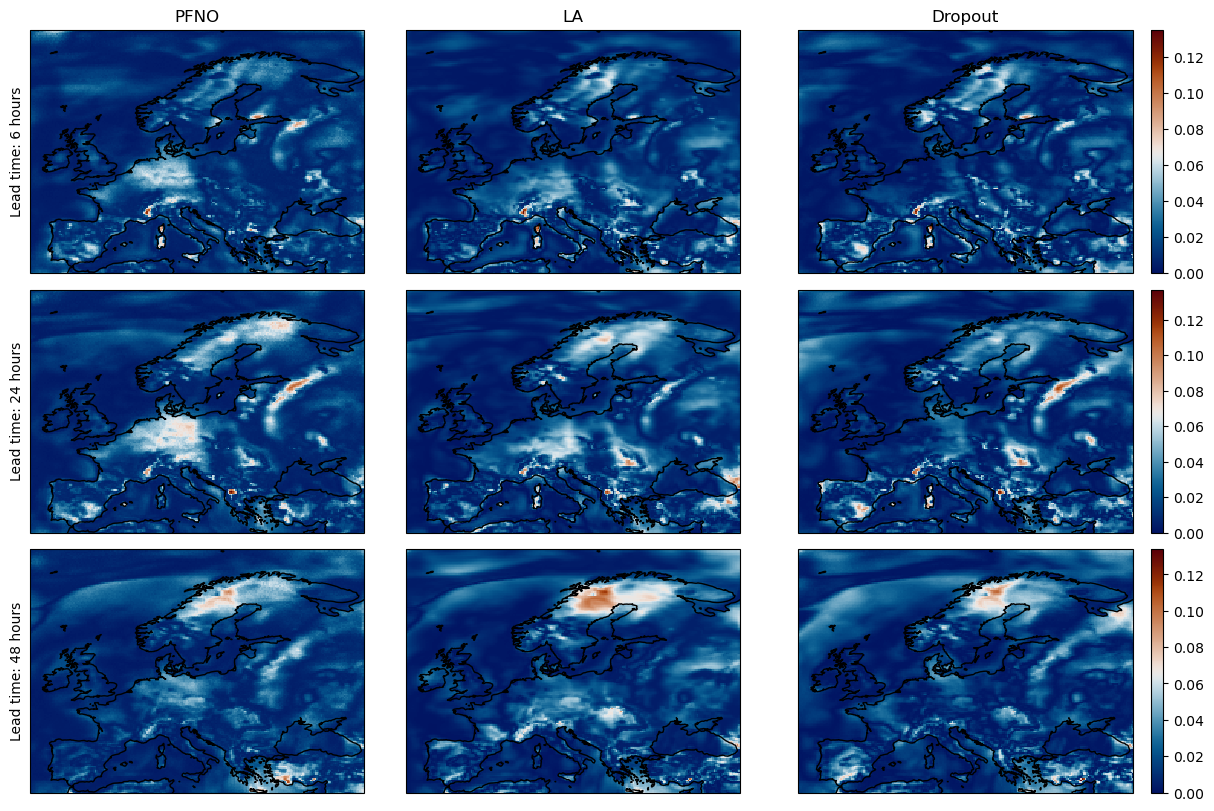

In [ ]:
times = [0,3,7]

pred_array = np.array(preds)


fig, axs = plt.subplots(3,3, figsize = (12,8),subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
for ax in axs.ravel():
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)

for t, time in enumerate(times):
    crps_norm = Normalize(vmin = 0, vmax = pred_array[:,:,:,t].max())
    for m, pred in enumerate(preds):        
        pred = pred[:,:,t].squeeze()
        im1 = axs[t,m].pcolormesh(lon, lat ,pred, shading = "nearest", cmap = "cmc.vik", norm = crps_norm)
        axs[0,m].set_title(names[m])
    fig.colorbar(im1, ax = axs[t,m])     
    axs[t,0].set_ylabel(f"Lead time: {6*(time+1)} hours")       

    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])
    axs[2,0].set_xticks([])
    axs[2,0].set_yticks([])

plt.savefig("plots/era5_crps.png", dpi = 300, bbox_inches = "tight")